In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [2]:
X_train = np.arange(0, 100, 1)
Y_train = np.sin(X_train)

X_test = np.arange(100, 200, 1)
Y_test = np.sin(X_test)

n_features = 1

train_series = Y_train
test_series = Y_test

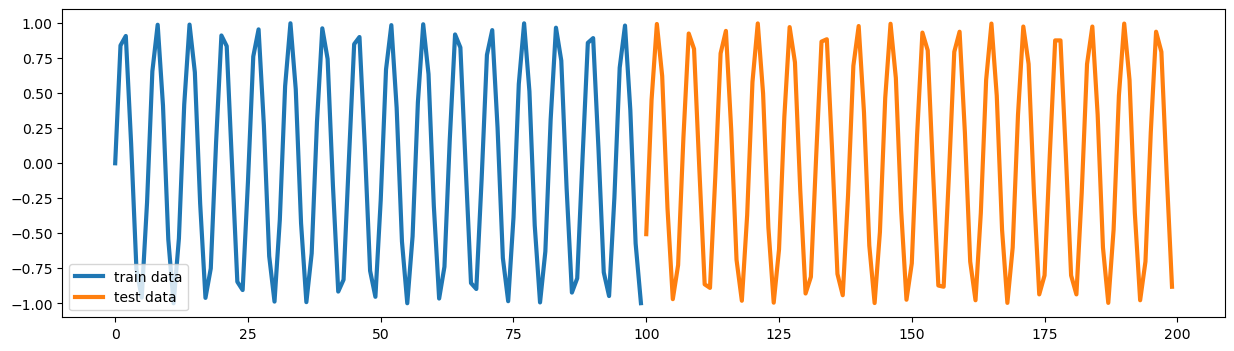

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))
ax.plot(X_train, Y_train, lw=3, label='train data')
ax.plot(X_test, Y_test, lw=3, label='test data')

ax.legend(loc="lower left")
plt.show()

In [5]:
train_series = torch.from_numpy(train_series)
test_series = torch.from_numpy(test_series)

In [8]:
look_back = 20

train_dataset = []
train_labels = []

for i in range(len(train_series) - look_back):
    train_dataset.append(train_series[i:i+look_back])   # sequensial한 데이터에서 예측 : [t0:t19] -> [t20] // [t1:t20] -> [t21] // ...
    train_labels.append(train_series[i+look_back])

train_dataset = torch.stack(train_dataset).unsqueeze(2) # 차원을 늘림, (2)번째 차원을 늘림
train_labels = torch.stack(train_labels).unsqueeze(1)   # (1)번째 차원을 늘림

# ex) unsqueeze(3)을 한다면? -> [80, 20, 1, 1]

In [9]:
print(train_dataset.shape)      # [batch, sequencial data(series size), input size]
print(train_labels.shape)       # [batch, output size]

torch.Size([80, 20, 1])
torch.Size([80, 1])


In [13]:
class Net(nn.Module):
    def __init__(self, n_neurons=4, input_shape=1):
        super(Net, self).__init__()

        self.rnn = nn.RNN(input_size=input_shape, hidden_size=n_neurons, batch_first=True)      # 입력의 크기, 히든 사이즈가 중요
        # self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons, batch_first=True)
        self.fc = nn.Linear(n_neurons, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        # out, _ = self,lstm(x)
        out = self.fc(out[:, -1, :])

        return out

In [14]:
model = Net().double()  # Need to recreate model and optimizer to reset hidden values
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_curve = []

for epoch in range(1000):
    loss_total = 0

    model.zero_grad()

    predictions = model(train_dataset)

    loss = loss_function(predictions, train_labels)
    loss_total += loss.item()
    loss.backward()
    optimizer.step()
    loss_curve.append(loss_total)

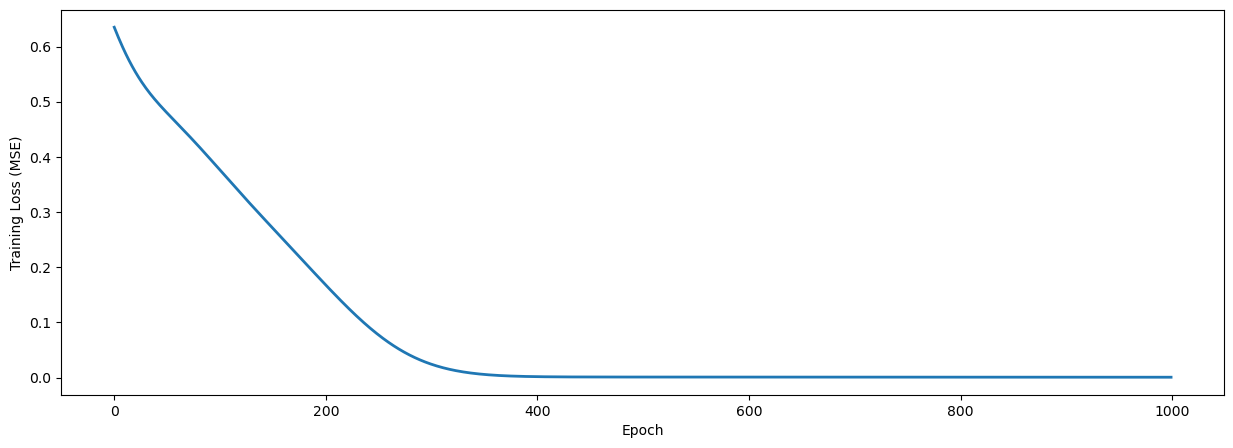

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(loss_curve, lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss (MSE)")

plt.show()

In [19]:
test_dataset = [test_series[i:i+20] for i in range(len(train_series) - look_back)]
test_dataset = torch.stack(test_dataset).unsqueeze(2)

test_predictions = []
for i in range(80):
    with torch.no_grad():
        res = model(test_dataset[:1, :,:])

        test_predictions.append(res)

        test_dataset = torch.concat((test_dataset[:1, :, :], res.unsqueeze(0)), dim = 1)
        test_dataset = test_dataset[:1, 1:, :]

res = torch.stack(test_predictions)
res = res.squeeze(1)

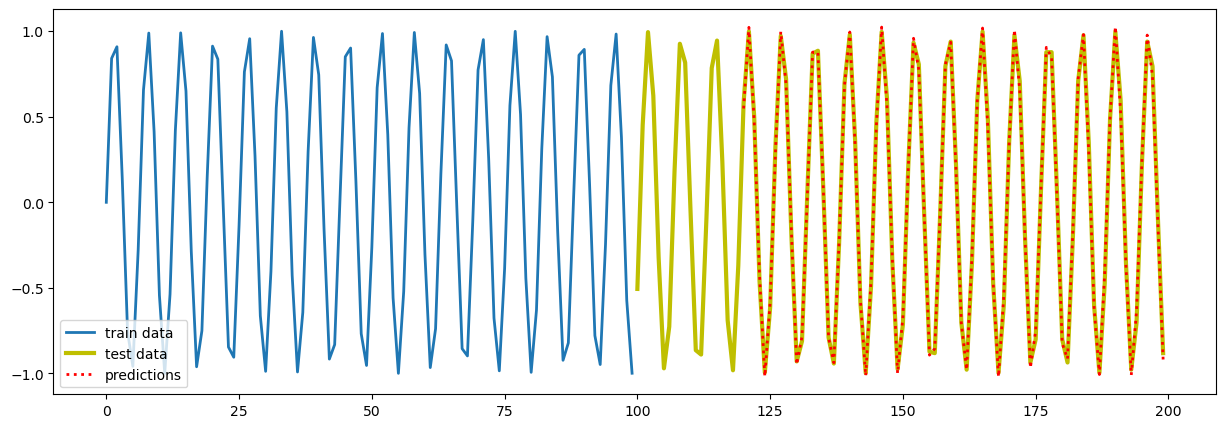

In [20]:
x = np.arange(120, 200, 1)
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train, Y_train, lw=2, label='train data')
ax.plot(X_test, Y_test, lw=3, c='y', label='test data')
ax.plot(x, res, lw=2, c='r', linestyle = ':', label='predictions')
ax.legend(loc="lower left")
plt.show()